In [1]:
import datasets
import typing as tp
from itertools import chain
from collections import defaultdict
import torch
from transformers import AutoModelForTokenClassification, AutoTokenizer
from tqdm import tqdm

# Load datasets
conll = datasets.load_dataset("conll2003", trust_remote_code=True)
wnut = datasets.load_dataset("wnut_17", trust_remote_code=True)

# Get tag names
CONLL_NER_TAGS = conll['train'].features['ner_tags'].feature.names
WNUT_NER_TAGS = wnut['train'].features['ner_tags'].feature.names

# Map WNUT to CoNLL label indices
label_mapping = {
    'O': 'O',
    'B-location': 'B-LOC', 'I-location': 'I-LOC',
    'B-group': 'B-ORG', 'B-corporation': 'B-ORG',
    'B-person': 'B-PER', 'I-person': 'I-PER',
    'B-creative-work': 'B-MISC', 'I-creative-work': 'I-MISC',
    'B-product': 'B-MISC', 'I-product': 'I-MISC',
    'I-corporation': 'I-ORG', 'I-group': 'I-ORG'
}
labelindexmapping = {WNUT_NER_TAGS.index(k): CONLL_NER_TAGS.index(v) for k, v in label_mapping.items()}

def convert_label_sequence(example, label_map):
    new_example = dict(**example)
    new_example['ner_tags'] = [label_map.get(tag, 0) for tag in example['ner_tags']]
    return new_example

converted_wnut = wnut.map(lambda x: convert_label_sequence(x, labelindexmapping))

# Load model/tokenizer
device = torch.device("cpu")
model = AutoModelForTokenClassification.from_pretrained("dslim/bert-base-NER").to(device)
tokenizer = AutoTokenizer.from_pretrained("dslim/bert-base-NER")

# Tokenization helper
def tokenize_and_preserve_tags(example: tp.Dict[str, tp.Any],
                               tokenizer: AutoTokenizer,
                               label2id: tp.Dict[str, int],
                               tokenizer_params={}) -> tp.Dict[str, tp.Any]:
    encoded = tokenizer(example["tokens"], is_split_into_words=True,
                        return_offsets_mapping=True, **tokenizer_params)
    word_ids = encoded.word_ids()

    new_labels = []
    new_text_labels = []
    previous_word_idx = None
    for word_idx in word_ids:
        if word_idx is None:
            new_labels.append(-100)
            new_text_labels.append("O")
        else:
            label = example["ner_tags"][word_idx]
            tag_str = CONLL_NER_TAGS[label]
            if word_idx != previous_word_idx:
                new_labels.append(label2id[tag_str])
                new_text_labels.append(tag_str)
            else:
                if tag_str.startswith("B-"):
                    tag_str = "I-" + tag_str[2:]
                new_labels.append(label2id[tag_str])
                new_text_labels.append(tag_str)
            previous_word_idx = word_idx

    encoded["labels"] = new_labels
    encoded["text_labels"] = new_text_labels
    return encoded

label2id = {tag: i for i, tag in enumerate(CONLL_NER_TAGS)}
conll = conll.map(lambda x: tokenize_and_preserve_tags(x, tokenizer, model.config.label2id))
wnut = converted_wnut.map(lambda x: tokenize_and_preserve_tags(x, tokenizer, model.config.label2id))

conll.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'labels'], output_all_columns=True)
wnut.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'labels'], output_all_columns=True)

# ✅ Fixed PadSequence class
class PadSequence:
    def __init__(self, padded_columns, device='cpu'):
        self.padded_columns = set(padded_columns)
        self.device = device

    def __call__(self, batch):
        padded_batch = defaultdict(list)
        for example in batch:
            for key, value in example.items():
                padded_batch[key].append(value)

        final_batch = {}
        for key, values in padded_batch.items():
            if isinstance(values[0], torch.Tensor):
                if key in self.padded_columns:
                    final_batch[key] = torch.nn.utils.rnn.pad_sequence(
                        values, batch_first=True).to(self.device)
                else:
                    final_batch[key] = torch.stack(values).to(self.device)
            else:
                final_batch[key] = values
        return final_batch

# Loaders
collate_fn = PadSequence(['input_ids', 'token_type_ids', 'attention_mask', 'labels'], device=device)
conll_loader = torch.utils.data.DataLoader(conll["test"], batch_size=16, collate_fn=collate_fn)
wnut_loader = torch.utils.data.DataLoader(wnut["test"], batch_size=16, collate_fn=collate_fn)

# Prediction class
class NamedEntityPredictor:
    def __init__(self, model, tokenizer, id2label=None):
        self.model = model
        self.tokenizer = tokenizer
        self.id2label = model.config.id2label if id2label is None else id2label

    def predict(self, batch):
        self.model.eval()
        with torch.no_grad():
            model_output = self.model(
                input_ids=batch["input_ids"],
                token_type_ids=batch.get("token_type_ids"),
                attention_mask=batch["attention_mask"],
                labels=batch.get("labels"),
                return_dict=True
            )
        indices = torch.argmax(model_output.logits, axis=2)
        indices = indices.detach().cpu().numpy()
        attention_mask = batch["attention_mask"].cpu().numpy()

        predicted_labels = []
        for i in range(len(indices)):
            label_ids = indices[i][attention_mask[i] == 1]
            predicted_labels.append([self.id2label[int(id_)] for id_ in label_ids])
        return {"predicted_labels": predicted_labels, "loss": model_output.loss, "logits": model_output.logits}

# Run prediction
ner = NamedEntityPredictor(model, tokenizer)
predicted_labels = {"wnut_test": [], "conll_test": []}

for batch in tqdm(conll_loader, desc="Predicting CoNLL"):
    predicted_labels["conll_test"].extend(ner.predict(batch)["predicted_labels"])

for batch in tqdm(wnut_loader, desc="Predicting WNUT"):
    predicted_labels["wnut_test"].extend(ner.predict(batch)["predicted_labels"])


Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Predicting WNUT: 100%|██████████| 81/81 [02:17<00:00,  1.70s/it]


In [2]:
conll_test_dataloader = torch.utils.data.DataLoader(conll["test"], batch_size=16, collate_fn=PadSequence(['input_ids', 'token_type_ids', 'attention_mask', 'labels']))
wnut_test_dataloader = torch.utils.data.DataLoader(wnut["test"], batch_size=16, collate_fn=PadSequence(['input_ids', 'token_type_ids', 'attention_mask', 'labels']))

In [14]:
from seqeval.metrics import classification_report, f1_score

In [15]:
conll_report = classification_report(y_true=[list(example["text_labels"]) for example in conll["test"]],
                                                     y_pred=predicted_labels["conll_test"])

In [16]:
wnut_report = classification_report(y_true=[list(example["text_labels"]) for example in wnut["test"]],
                                                    y_pred=predicted_labels["wnut_test"])

In [17]:
print(f"CONLL:\n {conll_report}")
print(f"WNUT:\n {wnut_report}")

CONLL:
               precision    recall  f1-score   support

         LOC       0.75      0.84      0.79      1668
        MISC       0.58      0.70      0.63       702
         ORG       0.71      0.82      0.76      1661
         PER       0.36      0.58      0.45      1617

   micro avg       0.58      0.74      0.65      5648
   macro avg       0.60      0.74      0.66      5648
weighted avg       0.61      0.74      0.66      5648

WNUT:
               precision    recall  f1-score   support

         LOC       0.45      0.51      0.48       150
        MISC       0.17      0.22      0.19       269
         ORG       0.16      0.30      0.21       231
         PER       0.30      0.30      0.30       429

   micro avg       0.24      0.31      0.27      1079
   macro avg       0.27      0.33      0.29      1079
weighted avg       0.26      0.31      0.28      1079



In [18]:
def get_sentence_embeddings(model, batch):
    model.eval()
    with torch.no_grad():
        return model.bert(input_ids=batch["input_ids"],
                          token_type_ids=batch["token_type_ids"],
                          attention_mask=batch["attention_mask"],
                          return_dict=True)["last_hidden_state"].cpu().numpy()[:,0]

In [19]:
X = []
Y = []

conll_train_dataloader = torch.utils.data.DataLoader(conll["train"], batch_size=32, collate_fn=PadSequence(['input_ids', 'token_type_ids', 'attention_mask', 'labels']))
wnut_train_dataloader = torch.utils.data.DataLoader(wnut["train"], batch_size=32, collate_fn=PadSequence(['input_ids', 'token_type_ids', 'attention_mask', 'labels']))

for batch in tqdm(conll_train_dataloader):
    X.append(get_sentence_embeddings(model, batch))
    Y.extend([0] * len(batch["input_ids"]))
    
for batch in tqdm(wnut_train_dataloader):
    X.append(get_sentence_embeddings(model, batch))
    Y.extend([1] * len(batch["input_ids"]))

100%|██████████| 107/107 [05:30<00:00,  3.09s/it]


In [21]:
import numpy as np

X = np.concatenate(X)
Y = np.array(Y)

In [23]:
from sklearn.linear_model import LogisticRegression

# Assume X and Y are already defined feature and label arrays
dataset_classifier = LogisticRegression(max_iter=1000)
dataset_classifier.fit(X, Y)


LogisticRegression(max_iter=1000)

In [24]:
wnut_test_scores = []

wnut_test_dataloader = torch.utils.data.DataLoader(wnut["test"], batch_size=32, collate_fn=PadSequence(['input_ids', 'token_type_ids', 'attention_mask', 'labels']))
for batch in tqdm(wnut_test_dataloader):
    x = get_sentence_embeddings(model, batch)
    wnut_test_scores.append(dataset_classifier.predict_proba(x)[:,1])
    

100%|██████████| 41/41 [02:43<00:00,  3.99s/it]


In [25]:
wnut_test_scores = np.concatenate(wnut_test_scores)

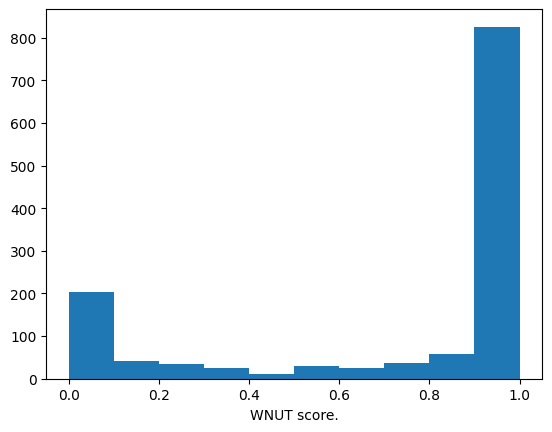

In [35]:
import matplotlib.pyplot as plt

plt.hist(wnut_test_scores)
plt.xlabel("WNUT score.")
plt.show()

In [36]:
score_indices = np.argsort(wnut_test_scores)

In [37]:
wnut_predicted_labels = np.array(predicted_labels["wnut_test"], dtype=object
                                )[np.argsort(wnut_test_scores)]

In [38]:
wnut_true_labels = np.array([list(example["text_labels"]) for example in wnut["test"]], dtype=object
                           )[np.argsort(wnut_test_scores)]

In [39]:
predicted_splits = np.array_split(wnut_predicted_labels, 5, )
true_splits = np.array_split(wnut_true_labels, 5)
score_splits = np.array_split(wnut_test_scores[np.argsort(wnut_test_scores)], 5)

In [40]:
print("score\tf1")
for scores, true_split, predicted_split in zip(score_splits, true_splits, predicted_splits):
    mean_score = np.mean(scores)
    f1 = f1_score(true_split, predicted_split)
    print(f"{mean_score:.3f}\t{f1:.3f}")

score	f1
0.055	0.446
0.693	0.325
0.986	0.299
0.999	0.197
1.000	0.145
